In [27]:
import os
import pandas as pd
import tensorflow as tf
from keras import Model
from keras.models import  Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [28]:
def load_data(dataset_path):
    def extract_age(file_name):
        return int(file_name.split('_')[0])

    def extract_file_path(file_name):
        return os.path.join(dataset_path, file_name)

    file_names = os.listdir(dataset_path)
    ages = pd.Series(file_names).apply(extract_age)
    file_paths = pd.Series(file_names).apply(extract_file_path)

    df = pd.DataFrame({'Images': file_paths, 'Ages': ages})

    return df


dataset_path = './Datasets/imdbwiki-200/'
df = load_data(dataset_path)

dataset_path = './Datasets/UTKFace/'

#df = load_data(dataset_path)

df = pd.concat([df,load_data(dataset_path)])
df # 100k images




,Images,Ages
0,./Datasets/imdbwiki-200/45_nm0000171_rm4064133...,45
1,./Datasets/imdbwiki-200/45_nm0604448_rm1603067...,45
2,./Datasets/imdbwiki-200/41_35847230_1972-03-07...,41
3,./Datasets/imdbwiki-200/15_nm1767820_rm3615668...,15
4,./Datasets/imdbwiki-200/19_nm0334159_rm5364587...,19
...,...,...
23703,./Datasets/UTKFace/26_0_1_20170116204952113.jp...,26
23704,./Datasets/UTKFace/59_1_2_20170104212726717.jp...,59
23705,./Datasets/UTKFace/56_1_0_20170104185820366.jp...,56
23706,./Datasets/UTKFace/40_0_0_20170117121759794.jp...,40


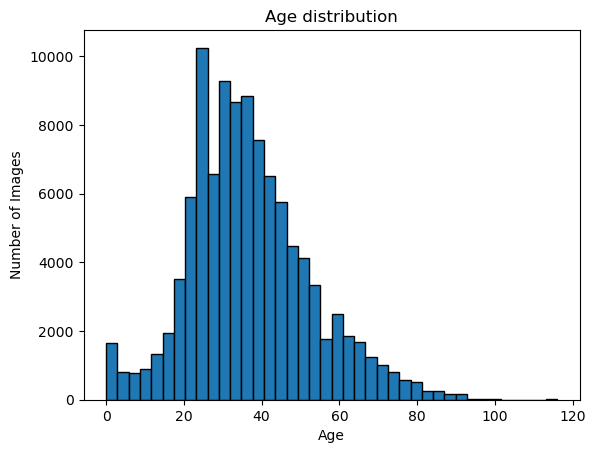

In [29]:
plt.hist(df['Ages'], bins=40, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

In [30]:
from sklearn.utils import resample

# define maximum number of samples to keep
max_samples = 500

# Split dataframe into several based on 'Ages'
dfs = [x for _, x in df.groupby('Ages')]

# Resample each dataframe
for i in range(len(dfs)):
    if i > 80:
        dfs[i] = None
    elif dfs[i].shape[0] < 2:
        dfs[i] = None

# Concatenate dataframes
df = pd.concat(dfs)  # 23k images


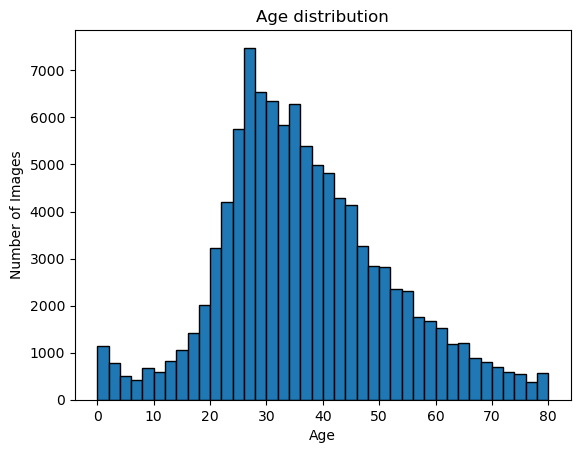

In [31]:
plt.hist(df['Ages'], bins=40, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()


In [32]:
from sklearn.utils import resample
import cv2
import numpy as np
import pandas as pd


def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()


def get_image_var(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return variance_of_laplacian(gray)


max_samples = 500

# Calculate variance of laplacian for each image and add to new column 'image_var'
df['image_var'] = df['Images'].apply(get_image_var)

# Split dataframe into several based on 'Ages'
dfs = [x for _, x in df.groupby('Ages')]

# Resample each dataframe
for i in range(len(dfs)):
    if dfs[i].shape[0] > max_samples:
        # Sort by 'image_var' column and reset index
        dfs[i] = dfs[i].sort_values(
            'image_var', ascending=False).reset_index(drop=True)
        # Resample the first 'max_samples' rows after sorting
        dfs[i] = resample(dfs[i].iloc[:max_samples, :],
                          replace=False, n_samples=max_samples, random_state=124)

df_downsampled = pd.concat(dfs)


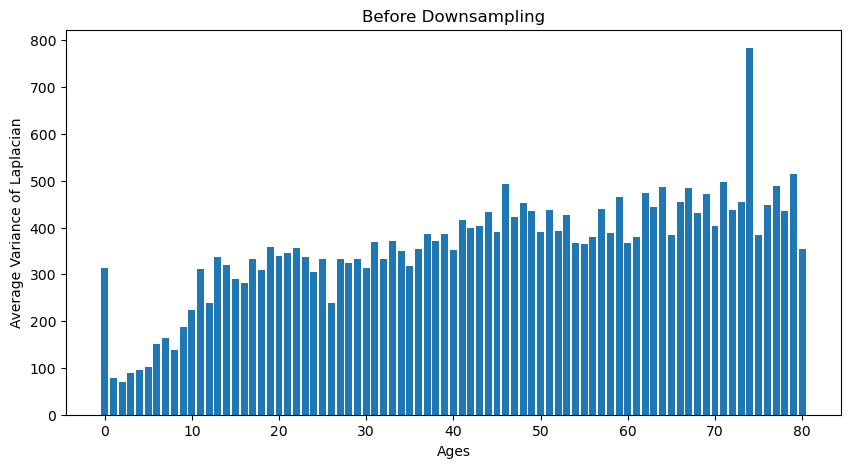

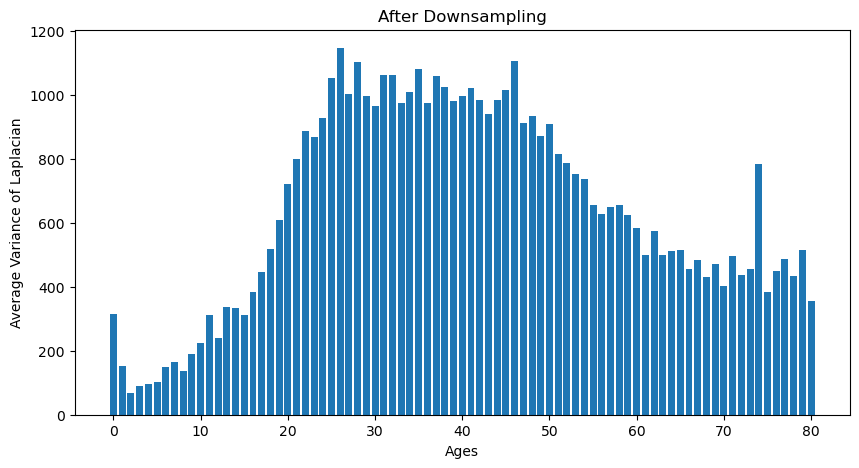

In [33]:
import matplotlib.pyplot as plt

average_var_before = df.groupby('Ages')['image_var'].mean()

# Calculate average variance of laplacian for each age group after downsampling
average_var_after = df_downsampled.groupby('Ages')['image_var'].mean()

# Convert series to dataframe for easier plotting
average_var_before = average_var_before.reset_index()
average_var_after = average_var_after.reset_index()

# Plot before downsampling
plt.figure(figsize=(10, 5))
plt.bar(average_var_before['Ages'], average_var_before['image_var'])
plt.xlabel('Ages')
plt.ylabel('Average Variance of Laplacian')
plt.title('Before Downsampling')
plt.show()

# Plot after downsampling
plt.figure(figsize=(10, 5))
plt.bar(average_var_after['Ages'], average_var_after['image_var'])
plt.xlabel('Ages')
plt.ylabel('Average Variance of Laplacian')
plt.title('After Downsampling')
plt.show()


In [34]:
df_downsampled

,Images,Ages,image_var
3970,./Datasets/imdbwiki-200/0_nm0001580_rm34770688...,0,377.585364
4852,./Datasets/imdbwiki-200/0_nm2762027_rm28686965...,0,283.425043
10466,./Datasets/imdbwiki-200/0_nm0000233_rm17660697...,0,347.070117
13022,./Datasets/imdbwiki-200/0_6802033_1964-01-13_1...,0,149.197105
18359,./Datasets/imdbwiki-200/0_32851434_1960-12-16_...,0,654.891187
...,...,...,...
22637,./Datasets/UTKFace/80_0_1_20170116003703261.jp...,80,368.087987
22901,./Datasets/UTKFace/80_0_0_20170117173759783.jp...,80,55.670891
22990,./Datasets/UTKFace/80_0_0_20170117175134292.jp...,80,49.548661
23387,./Datasets/UTKFace/80_1_0_20170110131358567.jp...,80,35.838599


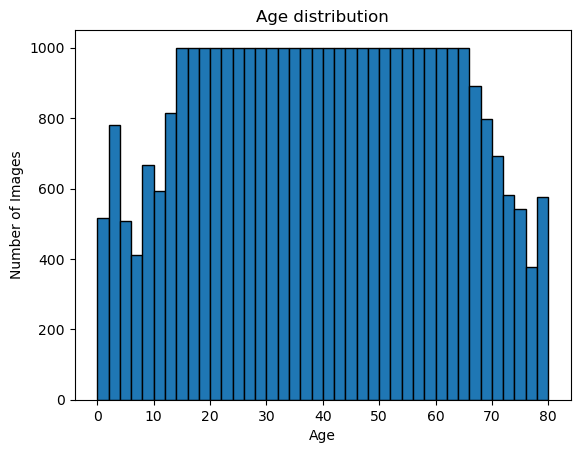

In [35]:
plt.hist(df_downsampled['Ages'], bins=40, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

In [36]:
train_df, test_df = train_test_split(df_downsampled, stratify=df_downsampled['Ages'], test_size=0.2, random_state=42)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Images',
    y_col='Ages',
    target_size=(200,200),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Images',
    y_col='Ages',
    target_size=(200,200),
    color_mode='grayscale',
    shuffle=False,
    class_mode='raw',
    batch_size=32,
)

Found 27800 validated image filenames.
Found 6950 validated image filenames.


In [ ]:
#train_generator.next()

In [ ]:
# for img,label in next(train_generator):
#         plt.imshow(img.astype('uint8'))  # convert float image to int for display
#         plt.show()
#         input()

In [ ]:
# import cv2
# import matplotlib.pyplot as plt
# import os
# import random

# # Set the path to the directory containing the images
# path_to_images = "./Datasets/imdbwiki-faces"

# # Get a list of all image filenames in the directory
# image_filenames = os.listdir(path_to_images)

# # Choose a random filename
# while True:
#     random_filename = random.choice(image_filenames)

#     # Construct the full path to the image
#     full_image_path = os.path.join(path_to_images, random_filename)

#     # Read the image using OpenCV
#     image = cv2.imread(full_image_path)

#     # Convert the image from BGR to RGB
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Display the image using matplotlib
#     plt.imshow(image)
#     plt.show()
#     input()

In [37]:

agemodel = Sequential()

agemodel.add(Conv2D(32, 5, activation='relu', input_shape=(200, 200, 1), padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(32, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))

agemodel.add(Conv2D(64, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(64, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))

agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))

agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))



agemodel.add(Flatten())
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))


agemodel.add(Dense(256, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(128, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(1, activation='relu'))


opt = tf.keras.optimizers.Adam(learning_rate=0.001)

agemodel.compile(optimizer=opt, loss='mse', metrics=['mae'])


In [38]:
agemodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 200, 200, 32)      832       
                                                                 
 batch_normalization_45 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 200, 200, 32)      25632     
                                                                 
 batch_normalization_46 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                      

In [40]:
import math
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=math.sqrt(0.1), patience=8, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=18, verbose=1, mode='min', restore_best_weights=True)

model_dir = './Models'
os.makedirs(model_dir, exist_ok=True)

# Check if file exists and create new filename if necessary
base_model_name = "best_model"
suffix = 0
while True:
    model_name = f"{base_model_name}_{suffix}.h5" if suffix > 0 else f"{base_model_name}.h5"
    model_path = os.path.join(model_dir, model_name)
    if not os.path.exists(model_path):
        break
    suffix += 1

model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [early_stopping, lr_scheduler, model_checkpoint]


In [ ]:
#agemodel = keras.models.load_model('Models/regression_mp_5_24.h5')
#agemodel.summary()

In [41]:
history = agemodel.fit(
    train_generator,
    epochs=512,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/512


2023-06-11 20:13:34.677849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


869/869 [==============================] - ETA: 0s - loss: 768.6481 - mae: 22.1498

2023-06-11 20:15:18.562282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 821.18921, saving model to ./Models/best_model_21.h5
869/869 [==============================] - 113s 123ms/step - loss: 768.6481 - mae: 22.1498 - val_loss: 821.1892 - val_mae: 22.9463 - lr: 0.0010
Epoch 2/512
869/869 [==============================] - ETA: 0s - loss: 401.9148 - mae: 16.0519
Epoch 2: val_loss improved from 821.18921 to 507.26691, saving model to ./Models/best_model_21.h5
869/869 [==============================] - 107s 123ms/step - loss: 401.9148 - mae: 16.0519 - val_loss: 507.2669 - val_mae: 18.0753 - lr: 0.0010
Epoch 3/512
869/869 [==============================] - ETA: 0s - loss: 356.3343 - mae: 14.8831
Epoch 3: val_loss improved from 507.26691 to 433.83643, saving model to ./Models/best_model_21.h5
869/869 [==============================] - 107s 123ms/step - loss: 356.3343 - mae: 14.8831 - val_loss: 433.8364 - val_mae: 16.8202 - lr: 0.0010
Epoch 4/512
869/869 [==============================] - ETA: 0s - loss: 324.3294 - mae: 14

In [42]:
# agemodel.load_weights("model_path")

predicted_ages = agemodel.predict(validation_generator)

mse = mean_squared_error(test_df['Ages'], predicted_ages)
mae = mean_absolute_error(test_df['Ages'], predicted_ages)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

  1/218 [..............................] - ETA: 38s

2023-06-11 22:15:58.904075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - 8s 37ms/step
Mean Squared Error: 93.21757179252758
Mean Absolute Error: 6.621006957832858


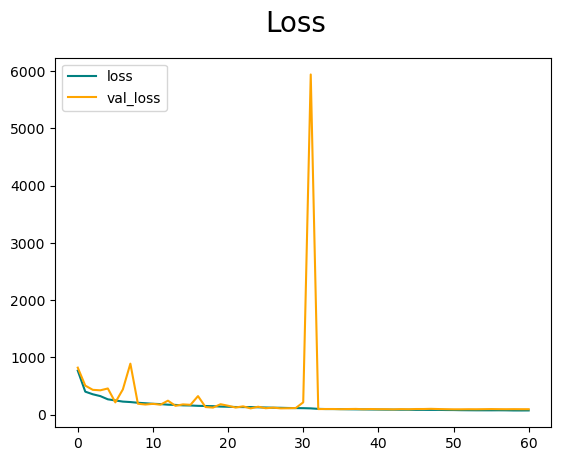

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

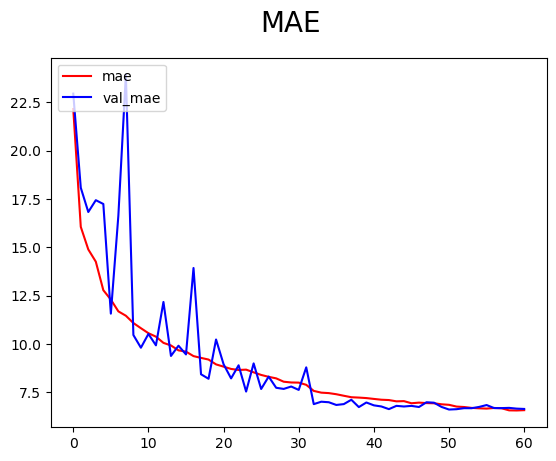

In [44]:
fig = plt.figure()
plt.plot(history.history['mae'], color='red', label='mae')
plt.plot(history.history['val_mae'], color='blue', label='val_mae')
fig.suptitle('MAE', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [17]:
new_model = tf.keras.models.load_model('./Models/5_04.h5')


In [18]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 200, 200, 32)      832       
                                                                 
 batch_normalization_30 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 200, 200, 32)      25632     
                                                                 
 batch_normalization_31 (Bat  (None, 200, 200, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                      

In [30]:
predicted_ages = new_model.predict(validation_generator)

mse = mean_squared_error(test_df['Ages'], predicted_ages)
mae = mean_absolute_error(test_df['Ages'], predicted_ages)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)


  1/218 [..............................] - ETA: 39s

2023-06-11 17:50:33.013580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - 8s 37ms/step
Mean Squared Error: 61.669769003543614
Mean Absolute Error: 5.504476637977491


In [ ]:
#agemodel.save(os.path.join('Models', 'regression_efficientNet_mp_4_99.h5'))